# Multi-class Classification
This notebook contains the code to experiment with the embeddings created by a fine-tuned S-BERT model for **multi-class classification**. Includes loading data, loading the model, and running different models for the classification

In [ ]:
! pip install \
  scprep\
  sentence_transformers==0.4.0 \
  phate==1.0.4

For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [ ]:
!rm -rf policy-data-analyzer/

In [ ]:
# Define branch to clone
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 642, done.
remote: Counting objects: 100% (642/642), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 3561 (delta 308), reused 486 (delta 161), pack-reused 2919
Receiving objects: 100% (3561/3561), 167.76 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (1855/1855), done.
Checking out files: 100% (853/853), done.


In [ ]:
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import time
import cupy as cp
import json

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loading.src.utils import *
from tasks.model_evaluation.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Run multi class classification experiments

### Data Loading

In [ ]:
experiment = "EXP17"
classifier = "Multiclass"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/{classifier}/"

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
print("Label names:", label_names)
print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

Label names: ['Direct payment', 'Tax deduction', 'Fine', 'Supplies', 'Technical assistance', 'Credit']
Train Sentence: La cantidad y tipo de plantas, producidas en los viveros comunitarios, así como el período de siembra, estarán definidas en función al sistema agroforestal y en los planes de trabajo elaborados por las/los Técnicos(as) en conjunto con las/los sujetos de derecho. 
Train Label: Supplies
Test Sentence: La metodología para la determinación del valor inicial de pago y el valor final de pago de la libra de azúcar a pagar a los productores se establecerá en el "Reglamento del Sistema de Pago de Caña de Azúcar". 
Test Label: Direct payment


### Load best model from training

In [ ]:
model_name = "paraphrase-xlm-r-multilingual-v1"
test_perc = 0.25
num_epochs = 2
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

saved_model_path = f"{base_path}/Modeling/{classifier}ClassificationExperiments/TESTS/{experiment}"

In [ ]:
saved_model = SentenceTransformer(saved_model_path)

In [ ]:
# Simple embeddings, no projection matrix added
train_sent_embs = encode_all_sents(train_sents, saved_model)
test_sent_embs = encode_all_sents(test_sents, saved_model)

100%|██████████| 134/134 [00:02<00:00, 50.96it/s]


### Test multiple classifiers
- Random Forests

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       0.88      0.88      0.88        26
      Direct payment       0.84      0.86      0.85        49
                Fine       0.90      0.95      0.92        19
            Supplies       0.00      0.00      0.00         8
       Tax deduction       0.89      0.80      0.84        10
Technical assistance       0.69      0.91      0.78        22

            accuracy                           0.83       134
           macro avg       0.70      0.73      0.71       134
        weighted avg       0.79      0.83      0.80       134



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/RandomForest_cm.png


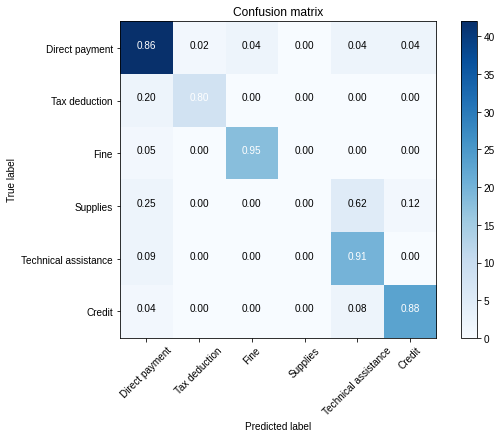

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/RandomForest")

- Support Vector Machines

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(np.vstack(train_sent_embs), train_labels)
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
print(classification_report(test_labels, clf_preds))

                      precision    recall  f1-score   support

              Credit       0.89      0.92      0.91        26
      Direct payment       0.89      0.82      0.85        49
                Fine       0.86      0.95      0.90        19
            Supplies       1.00      0.50      0.67         8
       Tax deduction       0.91      1.00      0.95        10
Technical assistance       0.81      0.95      0.88        22

            accuracy                           0.87       134
           macro avg       0.89      0.86      0.86       134
        weighted avg       0.88      0.87      0.87       134



Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/SVM_cm.png


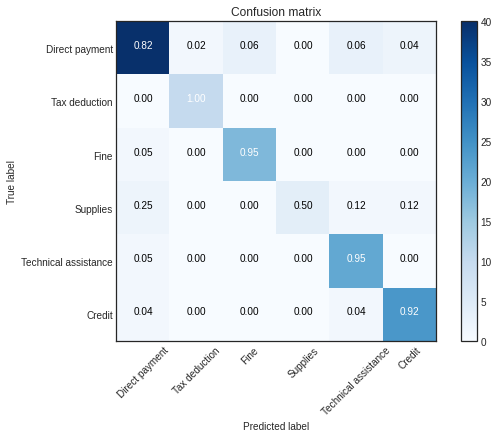

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/SVM")

- Gradient Boosting trees

In [ ]:
!pip install xgboost \
  catboost

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier)

In [ ]:
cb = CatBoostClassifier(n_estimators=2000,
                        colsample_bylevel=0.06,
                        max_leaves=31,
                        subsample=0.67,
                        verbose=0,
                        thread_count=6,
                        random_state=69420,
                        bootstrap_type='Poisson')

gbm = GradientBoostingClassifier(n_estimators=2000,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=69420)

lgbm = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

xgb = XGBClassifier(n_estimators=2000,
                    tree_method='hist',
                    subsample=0.67,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=69420)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)                          
ab = AdaBoostClassifier(base_estimator=base_estim,
                        n_estimators=500,
                        learning_rate=0.5,
                        random_state=69420)


Evaluating: LGBMClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       0.88      0.88      0.88        26
      Direct payment       0.87      0.82      0.84        49
                Fine       0.86      0.95      0.90        19
            Supplies       0.80      0.50      0.62         8
       Tax deduction       0.83      1.00      0.91        10
Technical assistance       0.88      0.95      0.91        22

            accuracy                           0.87       134
           macro avg       0.85      0.85      0.84       134
        weighted avg       0.86      0.87      0.86       134

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/LGBMClassifier_cm.png


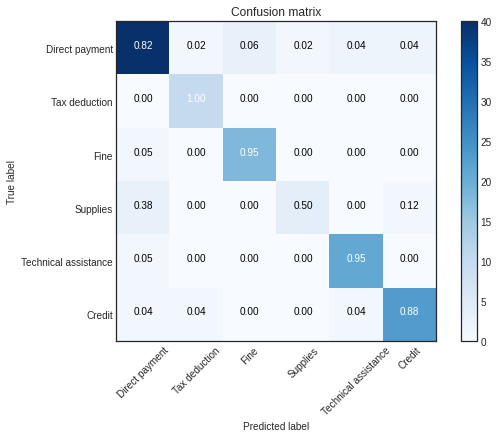

Evaluating: GradientBoostingClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       0.86      0.92      0.89        26
      Direct payment       0.88      0.88      0.88        49
                Fine       0.90      0.95      0.92        19
            Supplies       1.00      0.38      0.55         8
       Tax deduction       0.90      0.90      0.90        10
Technical assistance       0.88      0.95      0.91        22

            accuracy                           0.88       134
           macro avg       0.90      0.83      0.84       134
        weighted avg       0.89      0.88      0.87       134

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/GradientBoostingClassifier_cm.png


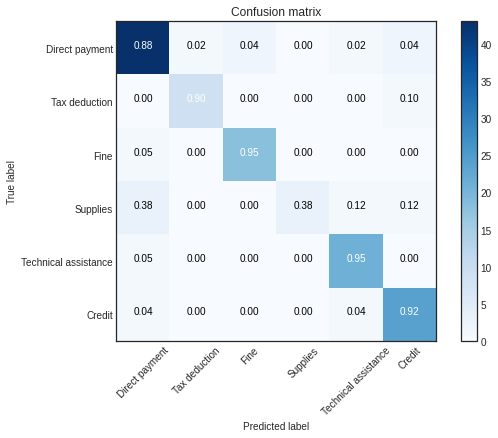

Evaluating: XGBClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       0.86      0.92      0.89        26
      Direct payment       0.89      0.82      0.85        49
                Fine       0.89      0.89      0.89        19
            Supplies       1.00      0.50      0.67         8
       Tax deduction       0.69      0.90      0.78        10
Technical assistance       0.80      0.91      0.85        22

            accuracy                           0.85       134
           macro avg       0.86      0.82      0.82       134
        weighted avg       0.86      0.85      0.85       134

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/XGBClassifier_cm.png


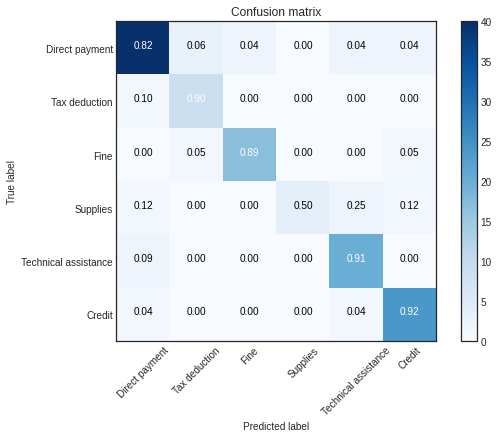

Evaluating: AdaBoostClassifier
Training...
Predicting...
                      precision    recall  f1-score   support

              Credit       1.00      0.85      0.92        26
      Direct payment       0.76      0.92      0.83        49
                Fine       0.89      0.89      0.89        19
            Supplies       1.00      0.38      0.55         8
       Tax deduction       0.89      0.80      0.84        10
Technical assistance       0.86      0.86      0.86        22

            accuracy                           0.85       134
           macro avg       0.90      0.78      0.82       134
        weighted avg       0.87      0.85      0.85       134

Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/TESTS/EXP17/AdaBoostClassifier_cm.png


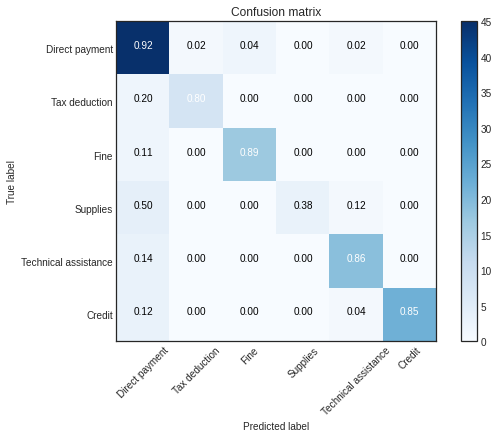

In [ ]:
gb_classifiers = [lgbm, gbm, xgb, ab] #cb
gb_names = [i.__class__.__name__ for i in gb_classifiers]

for clf, clf_name in zip(gb_classifiers, gb_names):
  print("Evaluating:", clf_name)
  print("Training...")
  clf.fit(np.vstack(train_sent_embs), train_labels)
  print("Predicting...")
  clf_preds = [clf.predict(sent_emb)[0] for sent_emb in test_sent_embs]
  print(classification_report(test_labels, clf_preds))
  numeric_preds = labels2numeric(clf_preds, label_names)
  numeric_test_labels = labels2numeric(test_labels, label_names)
  evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)
  evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{saved_model_path}/{clf_name}")